<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/BG_NBD_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [179]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import BetaGeoFitter, GammaGammaFitter
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [180]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [181]:
data["Total Amount"] = data["Quantity"]*data["Price"]

In [182]:
data.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Total Amount
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [183]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "Total Amount")

In [184]:
rfm_summary.reset_index(inplace = True)

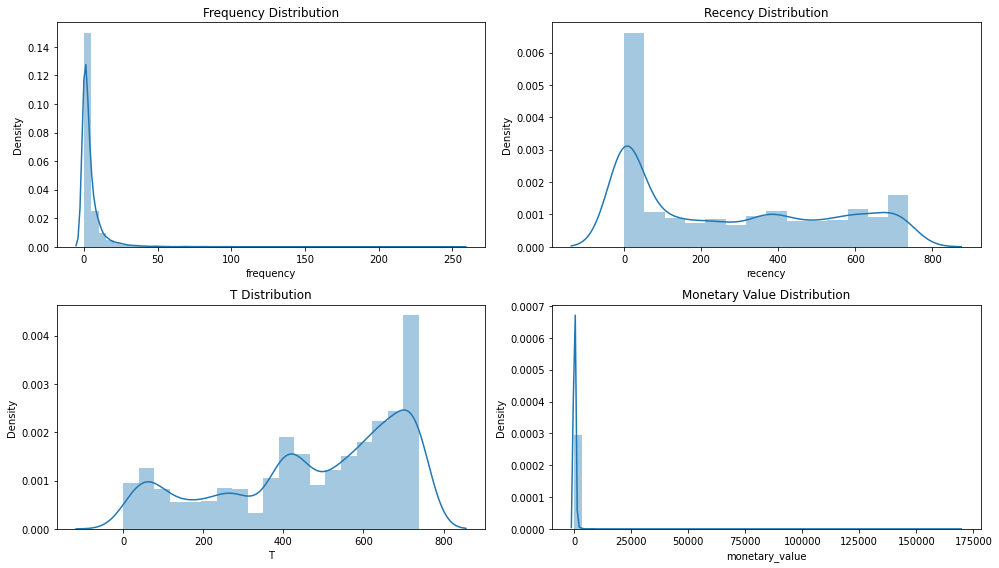

In [185]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

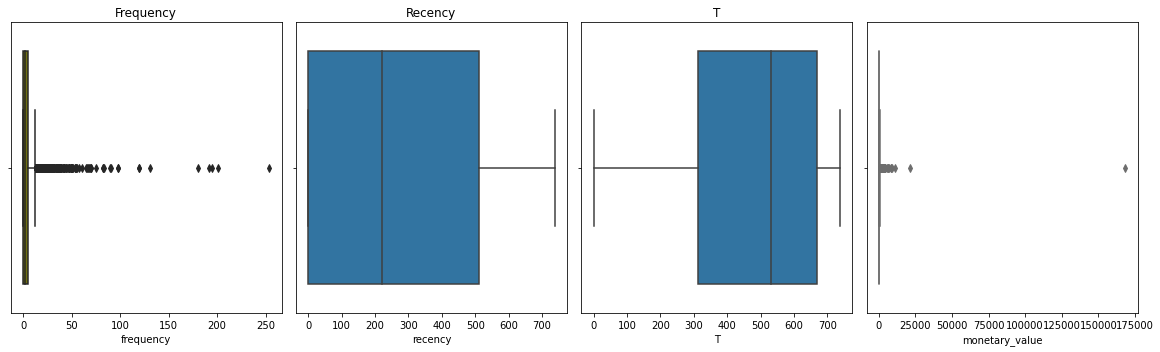

In [186]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "salmon")

plt.tight_layout()

In [187]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.632358,273.393671,474.260463,312.996109
std,1715.572666,9.999783,258.964160,223.090893,2255.743188
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,15.000000,0.000000
10%,12936.700000,0.000000,0.000000,89.000000,0.000000
25%,13833.250000,0.000000,0.000000,313.000000,0.000000
50%,15314.500000,2.000000,221.000000,530.000000,207.117500
75%,16797.750000,5.000000,512.000000,668.000000,368.045909
90%,17696.300000,11.000000,667.000000,730.000000,591.139417


In [188]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,7.0,400.0,725.0,11066.637143
1,12347,7.0,402.0,404.0,615.714286
2,12348,4.0,363.0,438.0,449.310000
3,12349,3.0,571.0,589.0,1120.056667
4,12350,0.0,0.0,310.0,0.000000


**Pareto/NBD Model**

In [189]:
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt

In [190]:
def get_model(data, penalizer_val, time):
    
    bgf_result = data.copy()

    bgf_model = BetaGeoFitter(penalizer_coef = penalizer_val)
    bgf_model.fit(bgf_result["frequency"], bgf_result["recency"], bgf_result["T"])

    #calculating the predicted_purchases

    t = time

    bgf_result["predicted_purchases"] = bgf_model.conditional_expected_number_of_purchases_up_to_time(t, bgf_result["frequency"], bgf_result["recency"], bgf_result["T"])


    bgf_result["Actual_Purchases"] = bgf_result["frequency"]/bgf_result["recency"]*time

    #filling the null values
    bgf_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    bgf_result["Prediction_Error"] = bgf_result["Actual_Purchases"]-bgf_result["predicted_purchases"]

    #calcuating the purchase prediction error
    bgf_mse_purchase = mean_squared_error(bgf_result["Actual_Purchases"], bgf_result["predicted_purchases"])
    bgf_r2_purchase = r2_score(bgf_result["Actual_Purchases"], bgf_result["predicted_purchases"])
    bgf_rmse_purchase = sqrt(mean_squared_error(bgf_result["Actual_Purchases"], bgf_result["predicted_purchases"]))
    bgf_avg_error_purchase = bgf_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(bgf_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(bgf_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(bgf_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(bgf_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(bgf_result["Actual_Purchases"], bgf_result["predicted_purchases"], yerr=bgf_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.222625935190549
Predicted Purchase R2 Score: 0.05883938106595221
Predicted Purchase Root Mean Squared Error: 1.490847388296518
Predicted Purchase Average Purchases Error: 0.231343694780076


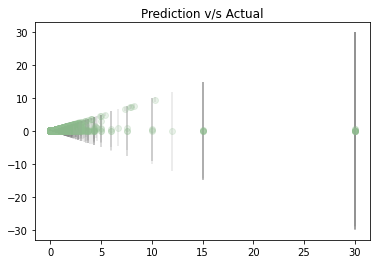

In [191]:
get_model(rfm_summary, 0.001, 30)

In [192]:
bgf_model = lifetimes.BetaGeoFitter(penalizer_coef = 0.1)

In [193]:
bgf_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.BetaGeoFitter: fitted with 5878 subjects, a: 0.02, alpha: 51.99, b: 0.24, r: 0.55>

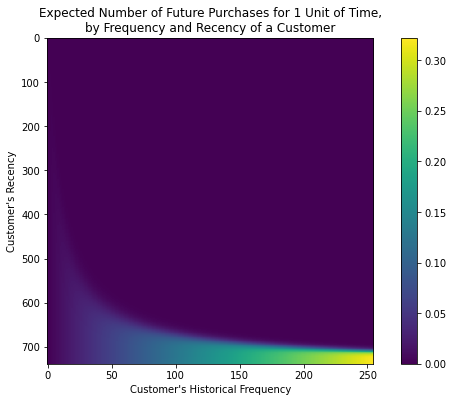

In [194]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf_model)

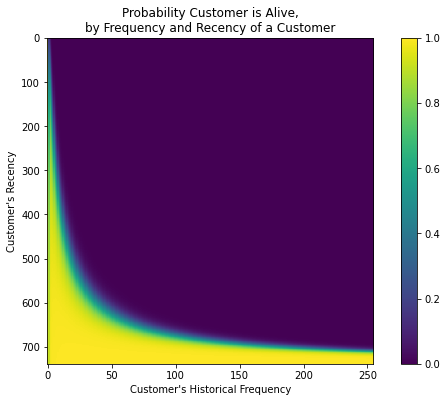

In [195]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf_model)

In [196]:
bgf_result = rfm_summary.copy()

In [197]:
bgf_result["p_not_alive"] = 1-bgf_model.conditional_probability_alive(bgf_result["frequency"], bgf_result["recency"], bgf_result["T"])
bgf_result["p_alive"] = bgf_model.conditional_probability_alive(bgf_result["frequency"], bgf_result["recency"], bgf_result["T"])

In [198]:
bgf_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,400.0,725.0,11066.637143,0.169782,0.830218
1,12347,7.0,402.0,404.0,615.714286,0.003530,0.996470
2,12348,4.0,363.0,438.0,449.310000,0.013850,0.986150
3,12349,3.0,571.0,589.0,1120.056667,0.010445,0.989555
4,12350,0.0,0.0,310.0,0.000000,0.000000,1.000000


In [199]:
t = 30
bgf_result["predicted_purchases"] = bgf_model.conditional_expected_number_of_purchases_up_to_time(t, bgf_result["frequency"], bgf_result["recency"], bgf_result["T"])

In [200]:
bgf_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346,7.0,400.0,725.0,11066.637143,0.169782,0.830218,0.241814
1,12347,7.0,402.0,404.0,615.714286,0.003530,0.996470,0.494392
2,12348,4.0,363.0,438.0,449.310000,0.013850,0.986150,0.274328
3,12349,3.0,571.0,589.0,1120.056667,0.010445,0.989555,0.164176
4,12350,0.0,0.0,310.0,0.000000,0.000000,1.000000,0.045134
...,...,...,...,...,...,...,...,...
5873,18283,18.0,655.0,658.0,142.666667,0.001340,0.998660,0.782277
5874,18284,0.0,0.0,431.0,0.000000,0.000000,1.000000,0.033867
5875,18285,0.0,0.0,660.0,0.000000,0.000000,1.000000,0.023001
5876,18286,1.0,247.0,723.0,833.480000,0.278337,0.721663,0.043189


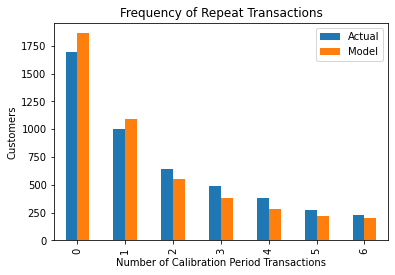

In [201]:
plot_period_transactions(bgf_model)

In [202]:
#dividing our dataset into training & holdout
bgf_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [203]:
bgf_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,400.0,541.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [204]:
bgf_model.fit(bgf_summary_cal_holdout["frequency_cal"],
               bgf_summary_cal_holdout["recency_cal"],
               bgf_summary_cal_holdout["T_cal"])

<lifetimes.BetaGeoFitter: fitted with 4960 subjects, a: 0.02, alpha: 53.80, b: 0.21, r: 0.55>

In [205]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

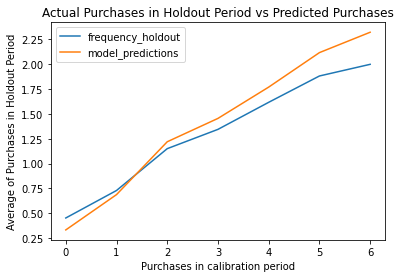

In [206]:
plot_calibration_purchases_vs_holdout_purchases(bgf_model, bgf_summary_cal_holdout)

In [207]:
bgf_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,400.0,541.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [208]:
bgf_result["actual30"] = bgf_result["frequency"]/bgf_result["recency"]*30

In [209]:
bgf_result["actual30"].fillna(0, inplace = True)

In [210]:
bgf_result["error"] = bgf_result["actual30"]-bgf_result["predicted_purchases"]

In [211]:
bgf_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,7.0,400.0,725.0,11066.637143,0.169782,0.830218,0.241814,0.525000,0.283186
1,12347,7.0,402.0,404.0,615.714286,0.003530,0.996470,0.494392,0.522388,0.027996
2,12348,4.0,363.0,438.0,449.310000,0.013850,0.986150,0.274328,0.330579,0.056251
3,12349,3.0,571.0,589.0,1120.056667,0.010445,0.989555,0.164176,0.157618,-0.006558
4,12350,0.0,0.0,310.0,0.000000,0.000000,1.000000,0.045134,0.000000,-0.045134


In [212]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 2.2151288851395847
Root Mean Squared Error: 1.488330905793327
R2 Score: 0.06201397205511927


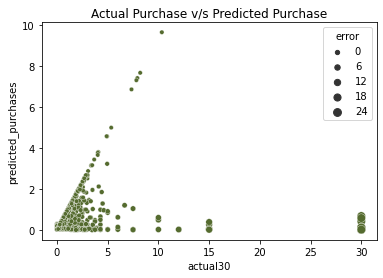

In [213]:
get_metrics(bgf_result["actual30"], bgf_result["predicted_purchases"], bgf_result["error"])

In [214]:
from lifetimes.plotting import plot_history_alive

In [215]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(bgf_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

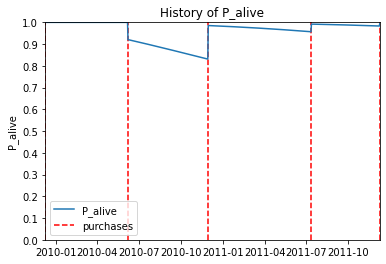

In [216]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [217]:
idx = bgf_result[(bgf_result["frequency"] <= 0.0)]

In [218]:
idx = idx.index

In [219]:
ggf_filter = bgf_result.drop(idx, axis = 0)

In [220]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [221]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [222]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

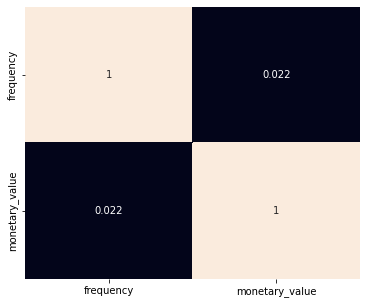

In [223]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [224]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [225]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.02, q: 0.18, v: 0.93>

In [226]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.019926,0.024531,0.971847,1.068006
q,0.179152,0.002996,0.173280,0.185024
v,0.933468,0.025489,0.883509,0.983426


In [227]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [228]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346,7.0,400.0,725.0,11066.637143,0.169782,0.830218,0.241814,0.525000,0.283186,12504.444266
1,12347,7.0,402.0,404.0,615.714286,0.003530,0.996470,0.494392,0.522388,0.027996,695.851827
2,12348,4.0,363.0,438.0,449.310000,0.013850,0.986150,0.274328,0.330579,0.056251,562.775336
3,12349,3.0,571.0,589.0,1120.056667,0.010445,0.989555,0.164176,0.157618,-0.006558,1531.122707
6,12352,8.0,356.0,392.0,338.261250,0.006048,0.993952,0.573574,0.674157,0.100584,376.226883


In [229]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 118446913.1865241
Root Mean Squared Error: 10883.331897287893
R2 Score: -15.7218443394684


In [230]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(bgf_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [231]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4061,16446,3.581217e+06
5692,18102,5.731532e+05
2277,14646,5.157381e+05
189,12536,3.688017e+05
1731,14096,3.462548e+05


In [232]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [233]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [234]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [235]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
0,12346,7.0,400.0,725.0,11066.637143,0.169782,0.830218,0.241814,0.525000,0.283186,12504.444266,79492.044302,3974.602215
1,12347,7.0,402.0,404.0,615.714286,0.003530,0.996470,0.494392,0.522388,0.027996,695.851827,8745.330300,437.266515
2,12348,4.0,363.0,438.0,449.310000,0.013850,0.986150,0.274328,0.330579,0.056251,562.775336,3930.359285,196.517964
3,12349,3.0,571.0,589.0,1120.056667,0.010445,0.989555,0.164176,0.157618,-0.006558,1531.122707,6409.972523,320.498626
6,12352,8.0,356.0,392.0,338.261250,0.006048,0.993952,0.573574,0.674157,0.100584,376.226883,5487.135225,274.356761


In [236]:
col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]

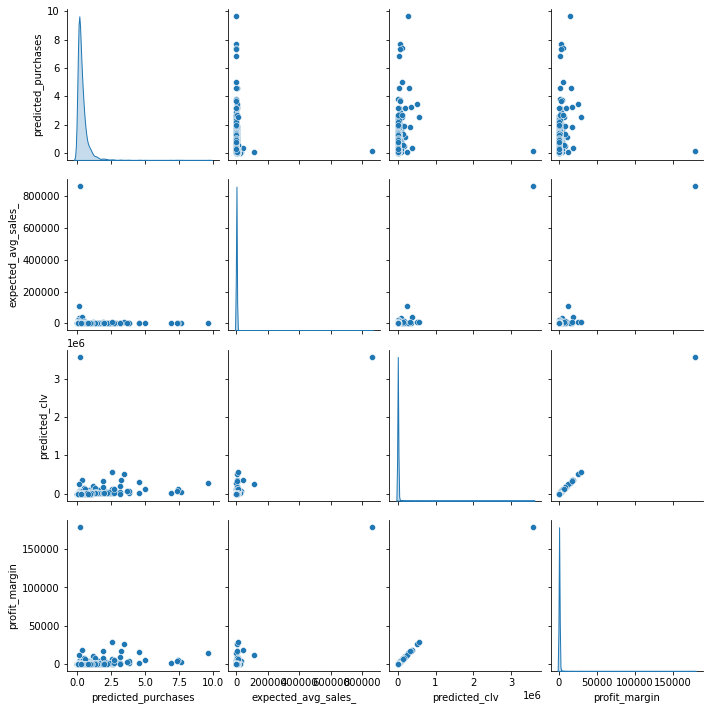

In [237]:
sns.pairplot(ggf_filter[col], diag_kind = "kde")

In [238]:
new_df = ggf_filter[col]
print(new_df)

      predicted_purchases  expected_avg_sales_  predicted_clv  profit_margin
0                0.241814         12504.444266   79492.044302    3974.602215
1                0.494392           695.851827    8745.330300     437.266515
2                0.274328           562.775336    3930.359285     196.517964
3                0.164176          1531.122707    6409.972523     320.498626
6                0.573574           376.226883    5487.135225     274.356761
...                   ...                  ...            ...            ...
5871             0.064173           418.842957     683.670923      34.183546
5872             0.237588           403.575690    2385.941573     119.297079
5873             0.782277           149.398387    2985.290044     149.264502
5876             0.043189          4274.903737    4731.746439     236.587322
5877             0.264994           741.876848    5014.641266     250.732063

[4189 rows x 4 columns]


In [239]:
### Data Standardization and Modeling with K-Means and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [240]:
#scaler = StandardScaler()
#df_std = scaler.fit_transform(ggf_filter)

In [241]:
#df_std = pd.DataFrame(data = df_std,columns = ggf_filter.columns)

In [242]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(new_df)
    inertia.append(kmeans.inertia_)

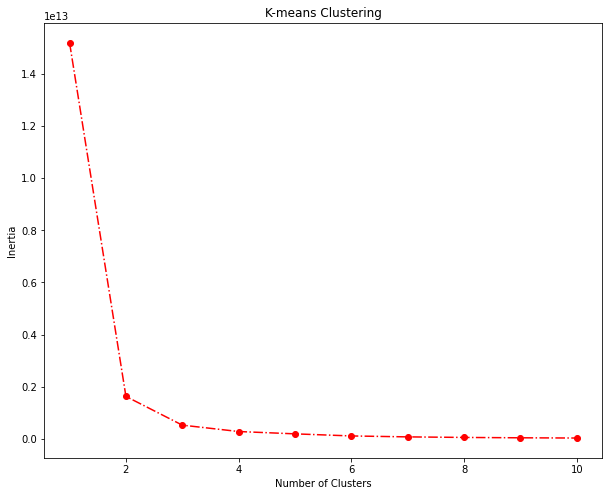

In [243]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [250]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [251]:
labels=kmeans.fit(new_df)

In [252]:
df_segm_kmeans= new_df.copy()
new_df['Segment K-means'] = kmeans.labels_

In [253]:
df_segm_analysis = new_df.groupby(['Segment K-means']).mean()
df_segm_analysis

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
0,0.332480,755.599392,4.605136e+03,230.256786
1,0.165569,863115.638821,3.581217e+06,179060.850722
2,3.216885,22851.828957,3.717051e+05,18585.252620
3,2.051253,4419.023791,8.972333e+04,4486.166369


In [254]:
df_segm_analysis.rename({0:'Low',
                         1:'High',
                         2:'Very High',
                         3:'Medium'})

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,
Low,0.332480,755.599392,4.605136e+03,230.256786
High,0.165569,863115.638821,3.581217e+06,179060.850722
Very High,3.216885,22851.828957,3.717051e+05,18585.252620
Medium,2.051253,4419.023791,8.972333e+04,4486.166369


In [255]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'Low',
                                                                  1:'High',
                                                                  2:'Very High',
                                                                  3:'Medium'})

In [256]:
df_segm_kmeans.head()

,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,0.241814,12504.444266,79492.044302,3974.602215,3,Medium
1,0.494392,695.851827,8745.330300,437.266515,0,Low
2,0.274328,562.775336,3930.359285,196.517964,0,Low
3,0.164176,1531.122707,6409.972523,320.498626,0,Low
6,0.573574,376.226883,5487.135225,274.356761,0,Low


In [258]:
ggf_filter = pd.concat([ggf_filter, df_segm_kmeans], axis = 1)

In [259]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,predicted_purchases,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,12346,7.0,400.0,725.0,11066.637143,0.169782,0.830218,0.241814,0.525000,0.283186,12504.444266,79492.044302,3974.602215,0.241814,12504.444266,79492.044302,3974.602215,3,Medium
1,12347,7.0,402.0,404.0,615.714286,0.003530,0.996470,0.494392,0.522388,0.027996,695.851827,8745.330300,437.266515,0.494392,695.851827,8745.330300,437.266515,0,Low
2,12348,4.0,363.0,438.0,449.310000,0.013850,0.986150,0.274328,0.330579,0.056251,562.775336,3930.359285,196.517964,0.274328,562.775336,3930.359285,196.517964,0,Low
3,12349,3.0,571.0,589.0,1120.056667,0.010445,0.989555,0.164176,0.157618,-0.006558,1531.122707,6409.972523,320.498626,0.164176,1531.122707,6409.972523,320.498626,0,Low
6,12352,8.0,356.0,392.0,338.261250,0.006048,0.993952,0.573574,0.674157,0.100584,376.226883,5487.135225,274.356761,0.573574,376.226883,5487.135225,274.356761,0,Low


In [262]:
ggf_filter.to_csv("Segmentation_result.csv")